In [1]:
import random
import numpy as np
import torch
from torch import nn
import torch.optim as optim

# multivariate data preparation
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt

import joblib 

In [2]:
data = np.loadtxt('./../tower_prep_data.csv', delimiter=',', dtype=np.float32, skiprows=1)

In [3]:
scaler_vibrations = joblib.load('./scalers/motor.gz')
scaler_temperature = joblib.load('./scalers/temperature.gz')
scaler_temperature_pir = joblib.load('./scalers/temperature_pir.gz')
scaler_start_stop = joblib.load('./scalers/start_stop.gz')

In [4]:
train_window = 60 * 160 #10000
offset = -1

In [5]:
train_window = 2000

In [6]:
dataset.size

NameError: name 'dataset' is not defined

In [7]:
dataset = data[: 19000, 3:-1]
type(dataset)

numpy.ndarray

In [8]:
dataset.size

57000

In [9]:
data.size

179305

In [10]:
dataset[:, 0]

array([ 0.19    , 15.351992,  0.48    , ..., 69.6     , 15.351992,
       60.48    ], dtype=float32)

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler3 = MinMaxScaler(feature_range=(-1, 1))
vibrations = scaler3.fit_transform(dataset[:, 0] .reshape(-1, 1))

scaler4 = MinMaxScaler(feature_range=(-1, 1))
temperature = scaler4.fit_transform(dataset[:, 1] .reshape(-1, 1))

scaler6 = MinMaxScaler(feature_range=(-1, 1))
temperature_pir = scaler6.fit_transform(dataset[:, 2] .reshape(-1, 1))

In [11]:
vibrations = scaler_vibrations.transform(np.log( dataset[:offset, 0] + 1e-15).reshape(-1, 1))
temperature = scaler_temperature.transform(dataset[:offset, 1] .reshape(-1, 1))
temperature_pir = scaler_temperature_pir.transform(dataset[:offset, 2] .reshape(-1, 1))

In [12]:
vibrations

array([[-1.757071 ],
       [ 0.2955367],
       [-1.3239452],
       ...,
       [ 0.2955367],
       [ 1.0019512],
       [ 0.2955367]], dtype=float32)

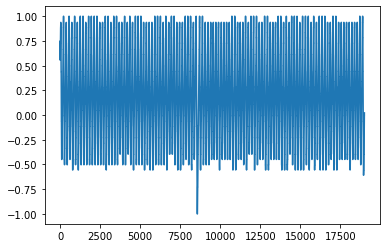

In [13]:
plt.plot(temperature[:])

In [14]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
        
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 6)
        )
        
    
    def forward(self, x):
        
        output = self.linear_relu_stack(x)
        return output

In [15]:
motor_model = torch.load("./models/motor.pt")

In [16]:
vibrations[-60:]

array([[0.6480587 ],
       [0.2955367 ],
       [0.9623106 ],
       [0.2955367 ],
       [0.8421139 ],
       [0.2955367 ],
       [0.8520282 ],
       [0.2955367 ],
       [0.8796095 ],
       [0.2955367 ],
       [0.2955367 ],
       [0.8854185 ],
       [0.2955367 ],
       [0.90647775],
       [0.2955367 ],
       [0.4929214 ],
       [0.2955367 ],
       [0.67612225],
       [0.2955367 ],
       [0.66021305],
       [0.2955367 ],
       [0.6326292 ],
       [0.2955367 ],
       [0.5638798 ],
       [0.2955367 ],
       [0.7412177 ],
       [0.2955367 ],
       [0.7145459 ],
       [0.2955367 ],
       [0.8711583 ],
       [0.2955367 ],
       [1.1218226 ],
       [0.2955367 ],
       [0.8121533 ],
       [0.2955367 ],
       [0.92123324],
       [0.2955367 ],
       [0.8528604 ],
       [0.2955367 ],
       [0.84662944],
       [0.2955367 ],
       [0.9842281 ],
       [0.2955367 ],
       [0.71578616],
       [0.2955367 ],
       [0.70131975],
       [0.2955367 ],
       [1.024

In [17]:
motor_model.eval()

with torch.no_grad():
    
    outputs = torch.tensor(vibrations[-60:].reshape(-1, 60))
#        scaler_vibrations.transform(test_data_x.reshape(-1,1)).reshape(-1, 60))
    #label = int(test_data_y[size])
        

    outputs = motor_model(outputs)
    _, predicted = torch.max(outputs, 1)
        
    print(predicted)

tensor([4])


In [18]:
pred_vibrations = np.empty(temperature.size)
pred_vibrations.fill(predicted.item()/5)

In [19]:
dataset = np.stack((pred_vibrations, temperature[:, 0]), axis=1)
#dataset = temperature[:, 0]

In [20]:
len(dataset)

18999

In [21]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 30 # number of hidden states
        self.n_layers = 3 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [22]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences) - 1):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1:
            break
        
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [23]:
X, y = split_sequences(dataset, n_timesteps)

NameError: name 'n_timesteps' is not defined

In [24]:
X[0]

NameError: name 'X' is not defined

In [25]:
y[0]

NameError: name 'y' is not defined

(18939, 60, 2) (18939,)
step :  0 loss :  0.23753322660923004
step :  1 loss :  0.22848738729953766
step :  2 loss :  0.213051438331604
step :  3 loss :  0.14364154636859894
step :  4 loss :  0.02893340215086937
step :  5 loss :  0.017567463219165802
step :  6 loss :  0.01615842804312706
step :  7 loss :  0.01473362185060978
step :  8 loss :  0.013357886113226414
step :  9 loss :  0.011986915953457355
tensor([0.0135])


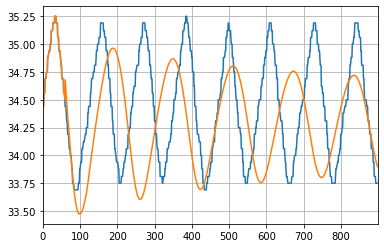

step :  0 loss :  0.01057577133178711
step :  1 loss :  0.009091755375266075
step :  2 loss :  0.0075318883173167706
step :  3 loss :  0.0059758988209068775
step :  4 loss :  0.004652594216167927
step :  5 loss :  0.0038550461176782846
step :  6 loss :  0.003580772317945957
step :  7 loss :  0.00351598858833313
step :  8 loss :  0.00348304258659482
step :  9 loss :  0.0034535203594714403
tensor([0.0141])


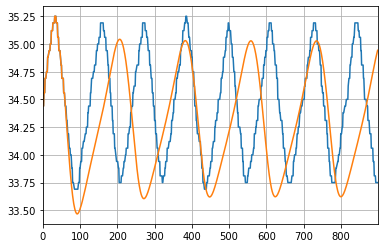

step :  0 loss :  0.0034252582117915154
step :  1 loss :  0.003397728782147169
step :  2 loss :  0.003370658028870821
step :  3 loss :  0.0033439085818827152
step :  4 loss :  0.003317407099530101
step :  5 loss :  0.0032910993322730064
step :  6 loss :  0.0032649480272084475
step :  7 loss :  0.0032389231491833925
step :  8 loss :  0.0032130081672221422
step :  9 loss :  0.003187192138284445
tensor([0.0142])


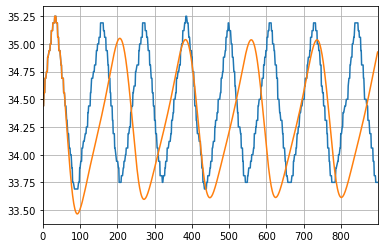

step :  0 loss :  0.0031614662148058414
step :  1 loss :  0.0031358308624476194
step :  2 loss :  0.003110283985733986
step :  3 loss :  0.0030848300084471703
step :  4 loss :  0.003059472655877471
step :  5 loss :  0.003034217283129692
step :  6 loss :  0.003009070875123143
step :  7 loss :  0.0029840406496077776
step :  8 loss :  0.002959132194519043
step :  9 loss :  0.0029343566857278347
tensor([0.0142])


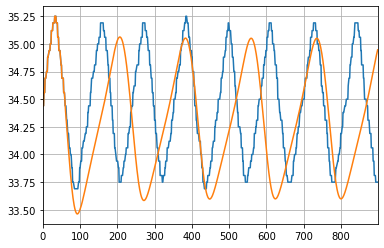

step :  0 loss :  0.002909720176830888
step :  1 loss :  0.002885231049731374
step :  2 loss :  0.0028608969878405333
step :  3 loss :  0.002836728235706687
step :  4 loss :  0.002812732011079788
step :  5 loss :  0.0027889178600162268
step :  6 loss :  0.0027652932330965996
step :  7 loss :  0.002741869306191802
step :  8 loss :  0.0027186525985598564
step :  9 loss :  0.002695652423426509
tensor([0.0142])


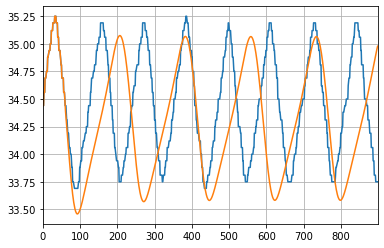

step :  0 loss :  0.0026728769298642874
step :  1 loss :  0.0026503370609134436
step :  2 loss :  0.0026280360762029886
step :  3 loss :  0.0026059842202812433
step :  4 loss :  0.0025841891765594482
step :  5 loss :  0.0025626537390053272
step :  6 loss :  0.0025413883849978447
step :  7 loss :  0.002520392881706357
step :  8 loss :  0.002499672817066312
step :  9 loss :  0.0024792321491986513
tensor([0.0143])


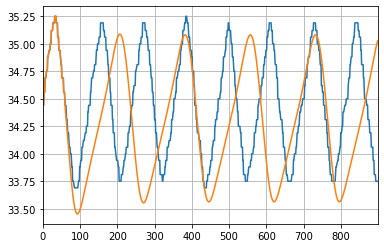

step :  0 loss :  0.0024590701796114445
step :  1 loss :  0.002439189702272415
step :  2 loss :  0.002419587690383196
step :  3 loss :  0.002400263212621212
step :  4 loss :  0.0023812123108655214
step :  5 loss :  0.0023624321911484003
step :  6 loss :  0.0023439142387360334
step :  7 loss :  0.002325655659660697
step :  8 loss :  0.0023076473735272884
step :  9 loss :  0.0022898793686181307
tensor([0.0144])


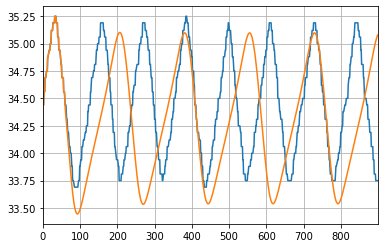

step :  0 loss :  0.0022723451256752014
step :  1 loss :  0.0022550327703356743
step :  2 loss :  0.0022379327565431595
step :  3 loss :  0.002221035538241267
step :  4 loss :  0.0022043269127607346
step :  5 loss :  0.002187799895182252
step :  6 loss :  0.002171439351513982
step :  7 loss :  0.002155238762497902
step :  8 loss :  0.0021391843911260366
step :  9 loss :  0.00212326948530972
tensor([0.0148])


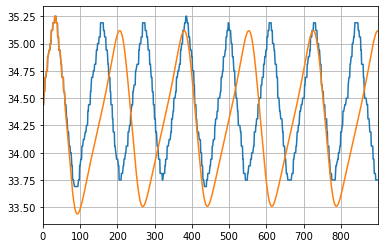

KeyboardInterrupt: 

In [27]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 60 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)
print(X.shape, y.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.0001)

train_episodes = 10
batch_size = 500

accuracy = 1

while(accuracy > 0.005):
    
    mv_net.train()
    for t in range(train_episodes):
        for b in range(0,len(X),batch_size):
            inpt = X[b:b+batch_size,:,:]
            target = y[b:b+batch_size]    

            x_batch = torch.tensor(inpt,dtype=torch.float32)    
            y_batch = torch.tensor(target,dtype=torch.float32)
            #print(x_batch)
            mv_net.init_hidden(x_batch.size(0))
        #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
        #    lstm_out.contiguous().view(x_batch.size(0),-1)
            output = mv_net(x_batch) 
            loss = criterion(output.view(-1), y_batch)  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad() 
        print('step : ' , t , 'loss : ' , loss.item())
    
    
    
    fut_pred = 900

    dataset_test = data[-train_window:, 3:-1].copy()#.tolist()
    dataset_test_l = data[-train_window:, 3:-1].tolist()


    #vibrations = scaler3.transform(dataset[:, 0] .reshape(-1, 1))
    #temperature = scaler4.transform(dataset_test[:, 1] .reshape(-1, 1))
    #temperature_pir = scaler6.transform(dataset_test[:, 2] .reshape(-1, 1))
    #vibrations = scaler_vibrations.fit_transform(np.log( dataset[:, 0] + 1e-15).reshape(-1, 1))
    temperature = scaler_temperature.transform(dataset_test[:, 1] .reshape(-1, 1))
    temperature_pir = scaler_temperature_pir.transform(dataset_test[:, 2] .reshape(-1, 1))
    
    #for x in range(len(temperature)):
        #dataset_test[x] = [vibrations[x][0], temperature[x][0], temperature_pir[x][0]]
     #   dataset_test[x] = [temperature[x][0], temperature_pir[x][0]]
    
    dataset_test = []

    #for x in range(len(temperature)):
    #    dataset_test.append([temperature[x][0], temperature_pir[x][0]])

    #dataset_test = np.array(dataset_test)
    pred_vibrations = np.empty(temperature.size)
    pred_vibrations.fill(predicted.item()/5)
    dataset_test = np.stack((pred_vibrations, temperature[:, 0]), axis=1)
    

    mv_net.eval()

    for i in range(fut_pred):

        seq = torch.FloatTensor([ dataset_test[i: i + n_timesteps]])
        #print(seq)
        
        #print(seq)

        with torch.no_grad():

            mv_net.init_hidden(seq.size(0))
            dataset_test[i + n_timesteps] = [dataset_test[i + n_timesteps][0], mv_net(seq).item()]


    dataset_test = torch.FloatTensor(dataset_test)
    dataset_test_l = torch.FloatTensor(dataset_test_l)
    temp = scaler_temperature.inverse_transform(np.array(dataset_test[:fut_pred, 1] ).reshape(-1, 1))
    

    sum = 0
    for i in range(fut_pred):

        sum += abs(dataset_test_l[i, 1] - temp[i]) / dataset_test_l[i, 1]

    accuracy = sum / fut_pred
    print(accuracy)
    
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(dataset_test_l[:fut_pred, 1])
    plt.plot(temp)
    #plt.plot(dataset_test[:fut_pred, 1])
    #plt.plot(temperature[:fut_pred])
    plt.show()


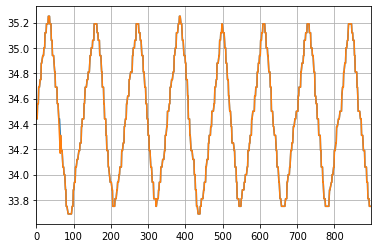

In [88]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
#plt.plot(dataset_test_l[:fut_pred, 1])
plt.plot(temp)
#plt.plot(dataset_test[:fut_pred, 1])
#plt.plot(temperature[:fut_pred])
plt.show()

In [ ]:
torch.save(mv_net, "./models/temperature2.pt")

In [11]:
torch.save(mv_net, "./models/temperature.pt")

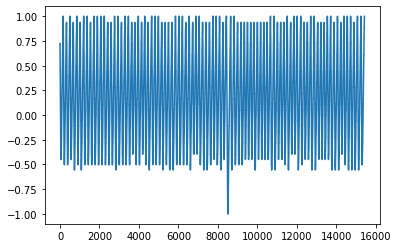

In [93]:
plt.plot(y)